# <font color='blue'>**LABORATORIO 2. Mejorando los resultados de clasificación sobre dataset "Adidas-Nike-Converse"**

<font color='red'>Integrantes: 
    
    Coloque los nombres completos con #ID UAO aqui (máximo 2 personas)


    Sebastian amilkar
    Milmax Duque

Adicione el código que sea necesario. No olvide comentarlo.

In [1]:
import numpy as np
import pandas as pd
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.keras.models as MK
import tensorflow.keras.layers as LK
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#%cd /content/drive/MyDrive/Cv2DL_2022_clase4/

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/computerVision/
!mkdir BagVisualWords_classCNN
%cd BagVisualWords_classCNN
!mkdir Cv2DL_2022_clase4
%cd Cv2DL_2022_clase4/
!pwd

/content/drive/MyDrive/Colab Notebooks/computerVision
mkdir: cannot create directory ‘BagVisualWords_classCNN’: File exists
/content/drive/MyDrive/Colab Notebooks/computerVision/BagVisualWords_classCNN
mkdir: cannot create directory ‘Cv2DL_2022_clase4’: File exists
/content/drive/MyDrive/Colab Notebooks/computerVision/BagVisualWords_classCNN/Cv2DL_2022_clase4
/content/drive/MyDrive/Colab Notebooks/computerVision/BagVisualWords_classCNN/Cv2DL_2022_clase4


# <font color='blue'> **Defining Model Architecture and Data .**

## Meeting Data

In [5]:
from tqdm.auto import tqdm
def load_RGB_resources(folder):
  etiquetas = os.listdir('train')
  print(etiquetas)
  images = []
  labels=[]
  for categoria in etiquetas:
    print("leyendo categoria", categoria)
    #se asigna un indice a la categoría, el cual servirá como una de las clases del vector target
    class_num = etiquetas.index(categoria)
    #folder será train o test
    ruta = os.path.join(folder,categoria)
    for img in tqdm(os.listdir(ruta)):
      # Se itera sobre la ruta Ej. train/adidas - y dentro de este folder habrá varias imágenes lo que haremos será leerlas y reedimensionarlas
      img_array = cv.imread(os.path.join(ruta, img), cv.COLOR_BGR2RGB)
      new_array = cv.resize(img_array,(224,224))
      # Se lee la imágen de la respectiva ruta, y como anteriormente se está iterando en
      #categoría, ingres la clase al vector de labels (target), y la imágen al array de imágenes
      #Se encuentran en el mismo orden por ende la clase corresponderá a la imágen Ej. Imagen de adidas - Corresponde a la clase adidas (class 0)
      images.append(new_array)
      labels.append(class_num)
  return np.array(images) , np.array(labels)

In [6]:
x_train, y_train = load_RGB_resources('train')
x_test, y_test= load_RGB_resources('test')

x_train = x_train.reshape((x_train.shape[0],224,224,3))
x_test = x_test.reshape((x_test.shape[0],224,224,3))

print("La dimensión de los datos para entrenamiento es: ", x_train.shape)
print("La dimensión de las etiquetas para los datos de entrenamiento es: ", y_train.shape)
print("La dimensión de los datos para validacion es: ", x_test.shape)
print("La dimensión de las etiquetas para los datos de validacion es: ", y_test.shape)



['adidas', 'converse', 'nike']
leyendo categoria adidas


  0%|          | 0/237 [00:00<?, ?it/s]

leyendo categoria converse


  0%|          | 0/237 [00:00<?, ?it/s]

leyendo categoria nike


  0%|          | 0/237 [00:00<?, ?it/s]

['adidas', 'converse', 'nike']
leyendo categoria adidas


  0%|          | 0/38 [00:00<?, ?it/s]

leyendo categoria converse


  0%|          | 0/38 [00:00<?, ?it/s]

leyendo categoria nike


  0%|          | 0/38 [00:00<?, ?it/s]

La dimensión de los datos para entrenamiento es:  (711, 224, 224, 3)
La dimensión de las etiquetas para los datos de entrenamiento es:  (711,)
La dimensión de los datos para validacion es:  (114, 224, 224, 3)
La dimensión de las etiquetas para los datos de validacion es:  (114,)


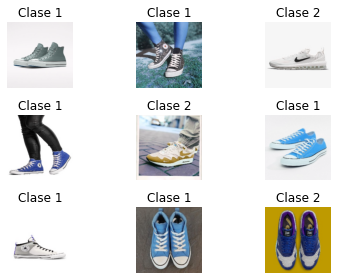

In [7]:
#Revisando algunas imagenes del dataset y corroborar informacion
fig, ax = plt.subplots(3,3)
[axi.set_axis_off() for axi in ax.ravel()]
ax = ax.flatten()
for i in ax:
  #ax[i[]].subplot(3,3,i+1)
  num = random.randint(0, len(x_train))
  i.imshow(x_train[num], cmap='gray')
  i.set_title("Clase {}".format(y_train[num]))
plt.tight_layout()
plt.show()

## Defining Utility Functions

In [8]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input as mobilenet_process_input

from keras.applications.resnet import ResNet101
from keras.applications.resnet import preprocess_input as resnet101_process_input

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_process_input

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input


In [9]:
def preprocess_data(x_train, y_train, x_test, y_test, preproces_input_algorithm):
  
  # convert image values from integers to floats
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  
  # normalization
  #x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
  #X_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
  x_train = preproces_input_algorithm(x_train)
  x_test = preproces_input_algorithm(x_test)

  # One-hot encoding label 
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  
  return x_train, y_train, x_test, y_test

In [10]:
def summary_history(history):
  # plot loss
	plt.subplot(121)
	plt.title('Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='red', label='test')
	plt.legend(['train', 'test'], loc='upper left')
	# plot accuracy
	plt.subplot(122)
	plt.title('Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='red', label='test')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()

In [11]:
def train_model(model, x_train, y_train, x_test, y_test, epochs = 50, batch_size = 80, callbacks=None , preproces_input_algorithm=None):
  # Rescaling all training and testing data
  x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test, preproces_input_algorithm )
  #x_train = preprocess_image_input(x_train)
  #x_test = preprocess_image_input(x_test)

  # Implement data augmentation
  datagen = ImageDataGenerator(horizontal_flip=True, zoom_range=0.1, rotation_range=0.2)
  it_train = datagen.flow(x_train, y_train, batch_size= batch_size)
  steps = int(x_train.shape[0] / batch_size)


  if type(callbacks) is tf.keras.callbacks:
    # Fitting the model on the training set
    history = model.fit(it_train, epochs = epochs, batch_size = batch_size,validation_data = (x_test, y_test), callbacks=[callbacks], steps_per_epoch=steps, verbose = 1)
  else:
    history = model.fit(it_train, epochs = epochs, batch_size = batch_size,validation_data = (x_test, y_test), steps_per_epoch=steps, verbose = 1)

  # evaluating the model
  #history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=batch_size,verbose=1)
  _, acc = model.evaluate(x_test, y_test, verbose = 1)
  print('accuracy: %.3f' % (acc * 100.0))
  return history

In [12]:
def cf_matrix(model,name):
  predic =model.predict(x_test)
  cm = confusion_matrix(y_test, predic.argmax(1))
  name = name
  plt.figure(figsize=(8,6))
  plt.title(name)
  sns.heatmap(cm, annot=True, fmt='g')
  plt.xticks(np.arange(cm.shape[0]), ['Adidas', 'Converse', 'Nike'], rotation=90)
  plt.yticks(np.arange(cm.shape[0]), ['Adidas', 'Converse', 'Nike'], rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

In [13]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001


## Defining Architectures

### VGG16

In [21]:
def vgg16_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = VGG16(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características
    modelo_base.trainable = trainable
    #-------------------------------------------------------------------
    # Si se requiere regularización entonces:
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    if regulable:
      regularizer = tf.keras.regularizers.l2(0.001)     
      modelo_vgg16 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,          
          # The first fully connected layer 
          LK.GlobalAveragePooling2D(),
          LK.Dense(512, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.BatchNormalization(),
          LK.Dropout(0.3),      
          LK.Dense(1024, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.Dropout(0.15),
          LK.Dense(2048, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.Dropout(0.3),
          LK.Dense(3, activation = "softmax")
      ])
      for i in range(len(modelo_vgg16.layers)):
        if isinstance(modelo_vgg16.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_vgg16.layers[i].name))
          modelo_vgg16.layers[i].kernel_regularizer = regularizer

      """for layer in modelo_vgg16.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)"""

    else:
      modelo_vgg16 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.GlobalAveragePooling2D(),
          LK.Dense(512, activation = "relu"),
          LK.BatchNormalization(),
          LK.Dense(1024, activation = "relu"),
          LK.Dense(2048, activation = "relu"),
          LK.Dense(3, activation = "softmax")
      ])
    #-----------------------------------------------------------------
    modelo_vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_vgg16

### ResNet101

In [22]:
from keras.applications.resnet import ResNet101
from tensorflow.keras import regularizers

In [23]:
def resnet101_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = ResNet101(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características
    modelo_base.trainable = trainable
    if regulable:
      regularizer = tf.keras.regularizers.l2(0.01) 
      modelo_resnet101 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.Flatten(),    
          LK.Dense(1024, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.Dense(1024, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.Dense(1024, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),              
          LK.Dense(3, activation=('softmax'))
      
      ])

      for i in range(len(modelo_resnet101.layers)):
        if isinstance(modelo_resnet101.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_resnet101.layers[i].name))
          modelo_resnet101.layers[i].kernel_regularizer = regularizer
    else:
      modelo_resnet101 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,  
          LK.Flatten(),    
          LK.Dense(1024, activation = "relu"),
          LK.Dense(1024, activation = "relu"),
          LK.Dense(1024, activation = "relu"),
          LK.Dense(3, activation=('softmax'))
      
      ])

    modelo_resnet101.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_resnet101

### InceptionV3

In [24]:
from keras.layers import Dense, GlobalAveragePooling2D

In [25]:
def inceptionV3_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características si está en True
    modelo_base.trainable = trainable
    if regulable:
      regularizer = tf.keras.regularizers.l2(0.001)
      modelo_inceptionV3 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.GlobalMaxPooling2D(),
          LK.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          LK.Dropout(0.3),
          LK.Dense(3,activation='softmax')
      
      ])
      for i in range(len(modelo_inceptionV3.layers)):
        if isinstance(modelo_inceptionV3.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_inceptionV3.layers[i].name))
          modelo_inceptionV3.layers[i].kernel_regularizer = regularizer

    else:
      modelo_inceptionV3 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.GlobalMaxPooling2D(),
          LK.Dense(2048, activation='relu'),
          LK.Dense(3,activation='softmax')
      
      ])

    modelo_inceptionV3.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_inceptionV3

# <font color='blue'>**(50%) Parte 1. Comparando VGG16 Vs Resnet 101 Vs InceptionV3 .**

* (10%) Estudie las  3 arquitecturas propuestas. De una breve explicación sobre los pros y los contras de cada una de ellas.

* (30%)Cargue los 3 modelos haciendo uso de los modelos disponibles en Keras applications. Cambie la(s) capa(s) que sean necesaria(s) para entrenar los 3 modelos sobre el dataset generado en el Laboratorio 1. No use transfer learning de manera que permita el entrenamiento de todas las capas. Puede usar cualquier combinación de metodos de regularización con el fin de obtener el mejor resultado para usted posible.

* (10%)Visualice las metricas de accuracy, loss y confusion matrix. Analice los resultados obtenidos y escriba al menos 3 conclusiones al respecto.



**vgg16**


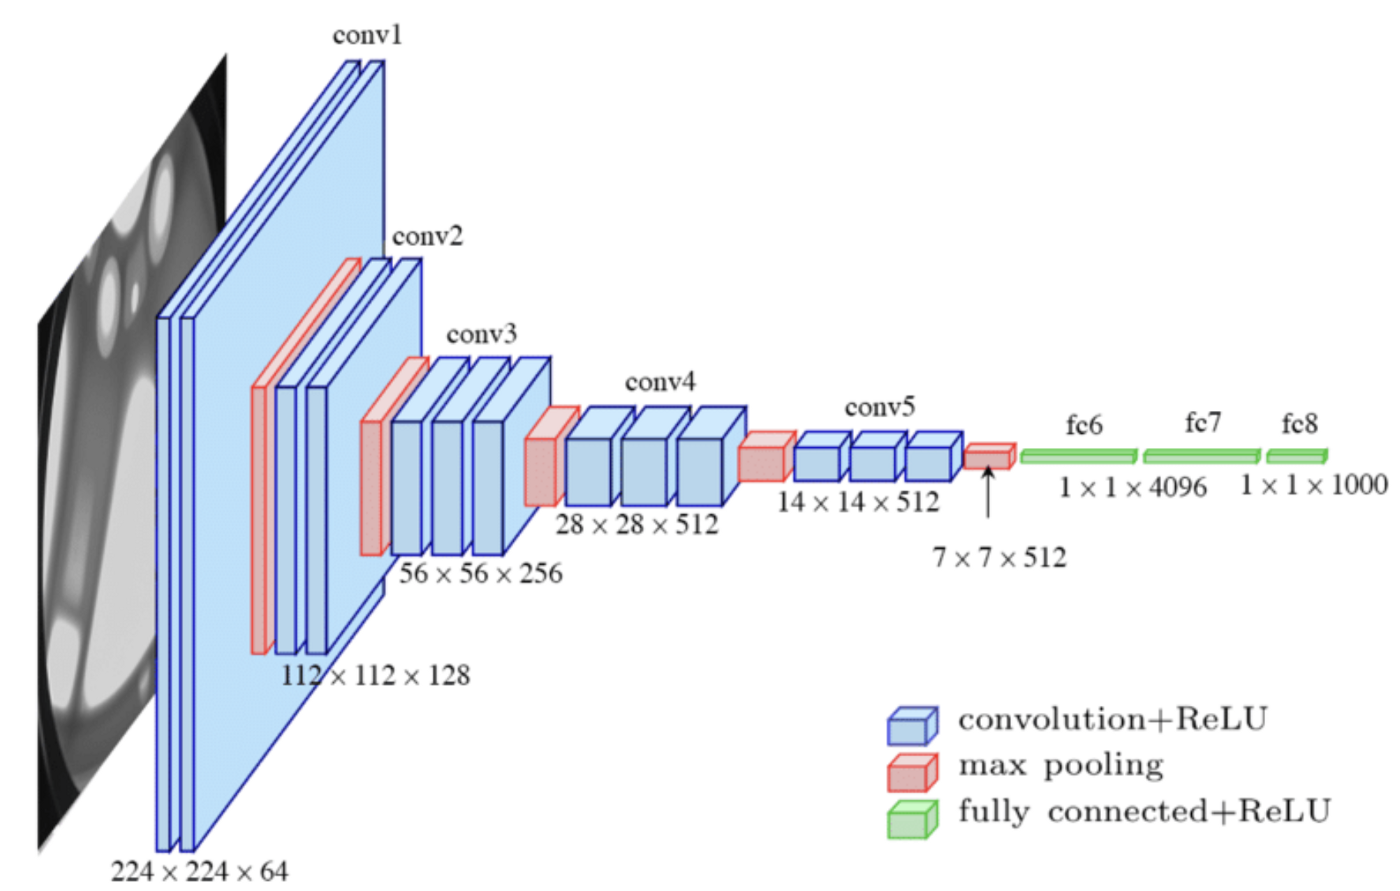

**ResNet101**


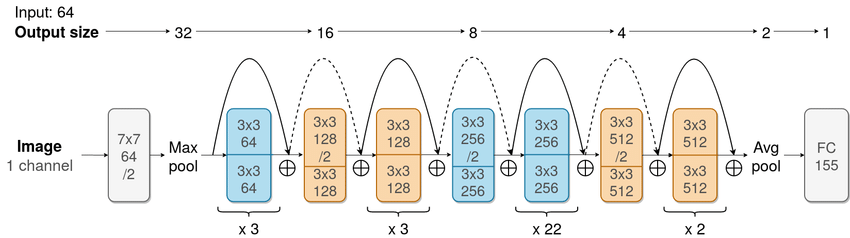


InceptionV3


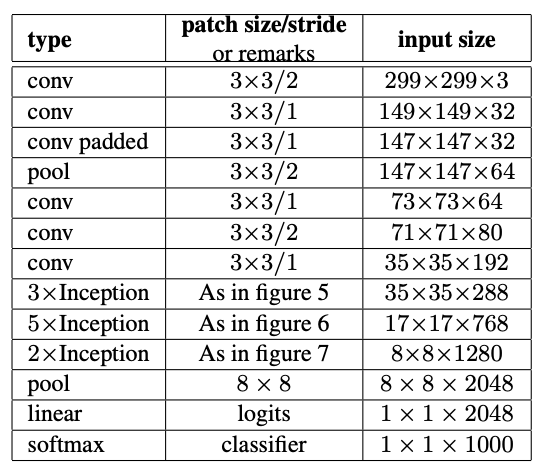

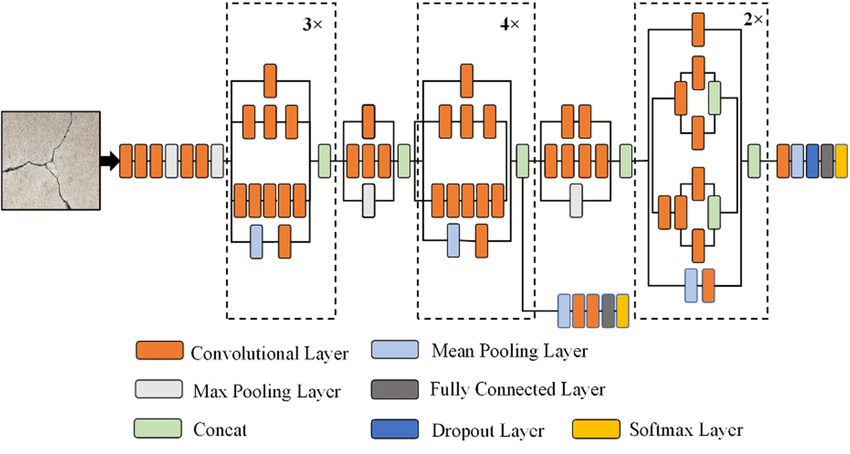

## Training Architectures - No regularization

### VGG16

In [26]:
vgg16_model = vgg16_architecture(trainable=True, regulable=False)


58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [27]:
#Coloque su código aquí
vgg16_history = train_model(vgg16_model, x_train, y_train, x_test, y_test, preproces_input_algorithm=vgg16_process_input)

Epoch 1/50
8/8 [==============================] - 39s 4s/step - loss: 1.0626 - accuracy: 0.4374 - val_loss: 2.1486 - val_accuracy: 0.4474
Epoch 2/50
8/8 [==============================] - 11s 1s/step - loss: 0.8542 - accuracy: 0.6323 - val_loss: 5.6445 - val_accuracy: 0.4211
Epoch 3/50
8/8 [==============================] - 11s 1s/step - loss: 0.5921 - accuracy: 0.7516 - val_loss: 3.7714 - val_accuracy: 0.5614
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 0.4213 - accuracy: 0.8177 - val_loss: 1.0688 - val_accuracy: 0.7368
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 0.2922 - accuracy: 0.8891 - val_loss: 0.6160 - val_accuracy: 0.7632
Epoch 6/50
8/8 [==============================] - 11s 1s/step - loss: 0.2114 - accuracy: 0.9281 - val_loss: 1.3375 - val_accuracy: 0.7895
Epoch 7/50
8/8 [==============================] - 11s 1s/step - loss: 0.1879 - accuracy: 0.9334 - val_loss: 1.2491 - val_accuracy: 0.7632
Epoch 8/50
8/8 [==================

### ResNet101

In [28]:
resnet101_model = resnet101_architecture(trainable=True, regulable=False)


Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [29]:
resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test,epochs=40, batch_size = 40, preproces_input_algorithm=resnet101_process_input)

Epoch 1/40
17/17 [==============================] - 27s 915ms/step - loss: 10.2612 - accuracy: 0.3413 - val_loss: 117914607616.0000 - val_accuracy: 0.3333
Epoch 2/40
17/17 [==============================] - 14s 810ms/step - loss: 1.1847 - accuracy: 0.4024 - val_loss: 156939568.0000 - val_accuracy: 0.3333
Epoch 3/40
17/17 [==============================] - 15s 854ms/step - loss: 0.9981 - accuracy: 0.5127 - val_loss: 435244.4062 - val_accuracy: 0.3333
Epoch 4/40
17/17 [==============================] - 14s 788ms/step - loss: 0.8869 - accuracy: 0.5842 - val_loss: 4389.4585 - val_accuracy: 0.3333
Epoch 5/40
17/17 [==============================] - 14s 803ms/step - loss: 0.8433 - accuracy: 0.5738 - val_loss: 646.8179 - val_accuracy: 0.3509
Epoch 6/40
17/17 [==============================] - 14s 785ms/step - loss: 0.8012 - accuracy: 0.6393 - val_loss: 36.1416 - val_accuracy: 0.2544
Epoch 7/40
17/17 [==============================] - 14s 792ms/step - loss: 0.7281 - accuracy: 0.6557 - val_loss

### InceptionV3

In [32]:
inceptionV3_model = inceptionV3_architecture(trainable=True, regulable=False)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [33]:
inceptionV3_history = train_model(inceptionV3_model, x_train, y_train, x_test, y_test, epochs=44, preproces_input_algorithm=inceptionv3_preprocess_input)

Epoch 1/44
8/8 [==============================] - 27s 2s/step - loss: 2.0142 - accuracy: 0.4025 - val_loss: 2.4892 - val_accuracy: 0.4825
Epoch 2/44
8/8 [==============================] - 8s 932ms/step - loss: 0.6982 - accuracy: 0.7607 - val_loss: 0.7029 - val_accuracy: 0.7105
Epoch 3/44
8/8 [==============================] - 8s 929ms/step - loss: 0.2970 - accuracy: 0.8875 - val_loss: 2.5023 - val_accuracy: 0.4474
Epoch 4/44
8/8 [==============================] - 9s 1s/step - loss: 0.1763 - accuracy: 0.9445 - val_loss: 1.1864 - val_accuracy: 0.7281
Epoch 5/44
8/8 [==============================] - 8s 929ms/step - loss: 0.0767 - accuracy: 0.9794 - val_loss: 0.8006 - val_accuracy: 0.7632
Epoch 6/44
8/8 [==============================] - 8s 934ms/step - loss: 0.0388 - accuracy: 0.9937 - val_loss: 1.0943 - val_accuracy: 0.7632
Epoch 7/44
8/8 [==============================] - 8s 927ms/step - loss: 0.0164 - accuracy: 0.9984 - val_loss: 1.2106 - val_accuracy: 0.7632
Epoch 8/44
8/8 [=========

## Visualizing - No regularization

### VGG16

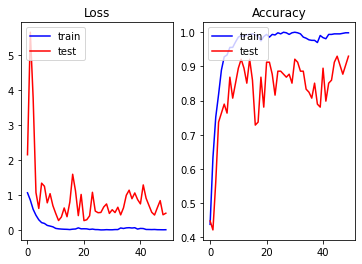

In [34]:
summary_history(vgg16_history)

4/4 [==============================] - 1s 157ms/step


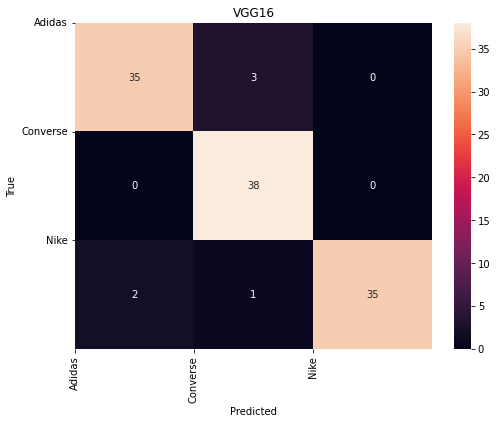

In [35]:
cf_matrix(vgg16_model,"VGG16")

### ResNet101

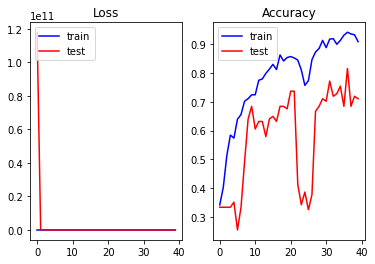

In [36]:
summary_history(resnet101_history)

4/4 [==============================] - 2s 170ms/step


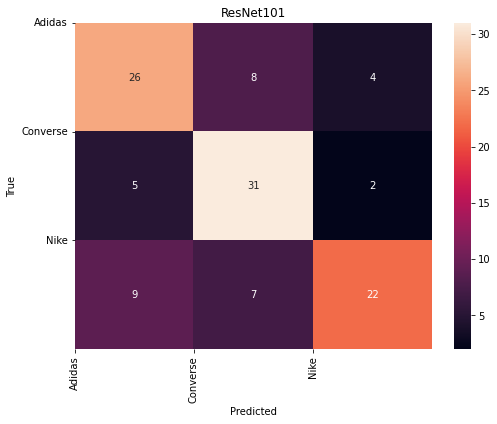

In [37]:
cf_matrix(resnet101_model,"ResNet101")

### InceptionV3

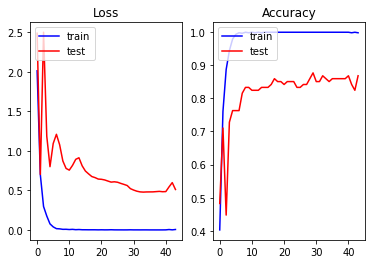

In [38]:
summary_history(inceptionV3_history)

4/4 [==============================] - 1s 65ms/step


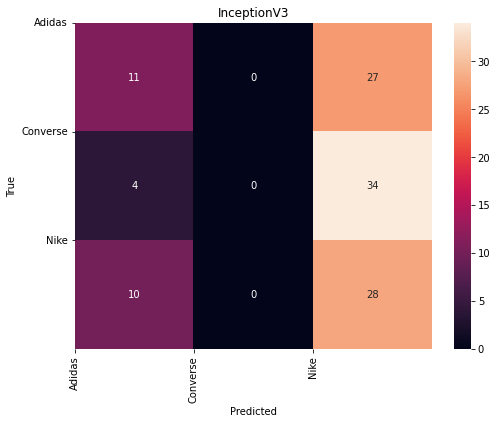

In [39]:
cf_matrix(inceptionV3_model,"InceptionV3")

 

##  With regularization



---



## Training Architectures -  with regularization

### VGG16

In [40]:
vgg16_model = vgg16_architecture(trainable=True, regulable=True)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:
#Coloque su código aquí
vgg16_history = train_model(vgg16_model, x_train, y_train, x_test, y_test, epochs=20, preproces_input_algorithm=vgg16_process_input)

Epoch 1/20
8/8 [==============================] - 13s 1s/step - loss: 26.6066 - accuracy: 0.3629 - val_loss: 33.5609 - val_accuracy: 0.3421
Epoch 2/20
8/8 [==============================] - 11s 1s/step - loss: 26.0240 - accuracy: 0.4612 - val_loss: 35.0881 - val_accuracy: 0.4474
Epoch 3/20
8/8 [==============================] - 11s 1s/step - loss: 25.4634 - accuracy: 0.5721 - val_loss: 30.0187 - val_accuracy: 0.3333
Epoch 4/20
8/8 [==============================] - 11s 1s/step - loss: 24.9040 - accuracy: 0.5959 - val_loss: 32.6938 - val_accuracy: 0.3596
Epoch 5/20
8/8 [==============================] - 11s 1s/step - loss: 24.2489 - accuracy: 0.6973 - val_loss: 26.1601 - val_accuracy: 0.5526
Epoch 6/20
8/8 [==============================] - 11s 1s/step - loss: 23.7451 - accuracy: 0.6926 - val_loss: 25.3790 - val_accuracy: 0.3947
Epoch 7/20
8/8 [==============================] - 11s 1s/step - loss: 23.1538 - accuracy: 0.7528 - val_loss: 26.1956 - val_accuracy: 0.5614
Epoch 8/20
8/8 [====

### ResNet101

In [42]:
resnet101_model = resnet101_architecture(trainable=True, regulable=True)


Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [43]:
resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test, batch_size=20, preproces_input_algorithm=resnet101_process_input)

Epoch 1/50
35/35 [==============================] - 33s 558ms/step - loss: 39.0340 - accuracy: 0.3459 - val_loss: 203.4258 - val_accuracy: 0.3333
Epoch 2/50
35/35 [==============================] - 16s 461ms/step - loss: 19.4528 - accuracy: 0.3719 - val_loss: 14.9205 - val_accuracy: 0.3421
Epoch 3/50
35/35 [==============================] - 16s 458ms/step - loss: 12.2189 - accuracy: 0.3459 - val_loss: 10.5915 - val_accuracy: 0.3333
Epoch 4/50
35/35 [==============================] - 16s 452ms/step - loss: 9.1604 - accuracy: 0.3748 - val_loss: 8.1826 - val_accuracy: 0.3421
Epoch 5/50
35/35 [==============================] - 16s 448ms/step - loss: 7.4946 - accuracy: 0.3936 - val_loss: 7.0227 - val_accuracy: 0.3860
Epoch 6/50
35/35 [==============================] - 16s 456ms/step - loss: 6.4401 - accuracy: 0.4139 - val_loss: 6.0492 - val_accuracy: 0.3421
Epoch 7/50
35/35 [==============================] - 16s 459ms/step - loss: 5.6606 - accuracy: 0.4732 - val_loss: 5.3359 - val_accuracy:

### InceptionV3

In [44]:
inceptionV3_model = inceptionV3_architecture(trainable=True, regulable=True)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_190 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

In [45]:
inceptionV3_history = train_model(inceptionV3_model, x_train, y_train, x_test, y_test, preproces_input_algorithm=inceptionv3_preprocess_input)

Epoch 1/50
8/8 [==============================] - 17s 1s/step - loss: 4.0300 - accuracy: 0.3914 - val_loss: 4.3691 - val_accuracy: 0.4825
Epoch 2/50
8/8 [==============================] - 8s 946ms/step - loss: 3.0664 - accuracy: 0.6656 - val_loss: 3.4114 - val_accuracy: 0.5877
Epoch 3/50
8/8 [==============================] - 8s 940ms/step - loss: 2.5336 - accuracy: 0.7940 - val_loss: 3.1446 - val_accuracy: 0.6404
Epoch 4/50
8/8 [==============================] - 8s 939ms/step - loss: 2.2299 - accuracy: 0.9208 - val_loss: 2.6579 - val_accuracy: 0.7895
Epoch 5/50
8/8 [==============================] - 8s 932ms/step - loss: 2.1401 - accuracy: 0.9588 - val_loss: 2.7084 - val_accuracy: 0.8333
Epoch 6/50
8/8 [==============================] - 8s 923ms/step - loss: 2.0675 - accuracy: 0.9873 - val_loss: 2.8287 - val_accuracy: 0.8070
Epoch 7/50
8/8 [==============================] - 8s 933ms/step - loss: 2.0539 - accuracy: 0.9842 - val_loss: 2.7863 - val_accuracy: 0.8421
Epoch 8/50
8/8 [======

## Visualizing - with regularization

### VGG16

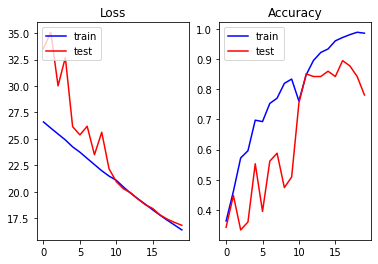

In [46]:
summary_history(vgg16_history)

4/4 [==============================] - 1s 157ms/step


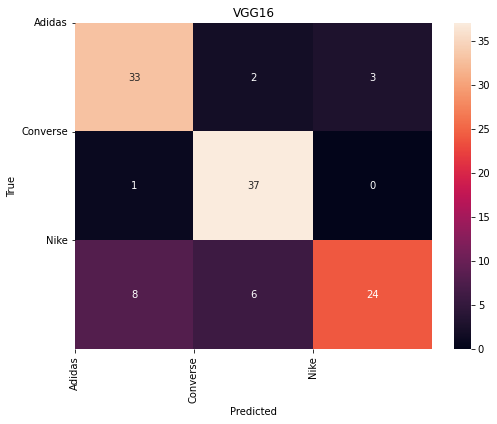

In [47]:
cf_matrix(vgg16_model,"VGG16")

### ResNet101

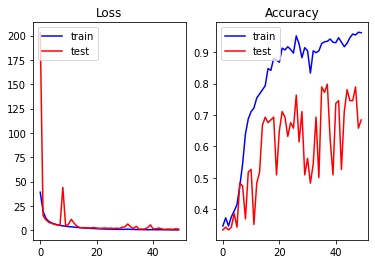

In [48]:
summary_history(resnet101_history)

4/4 [==============================] - 2s 170ms/step


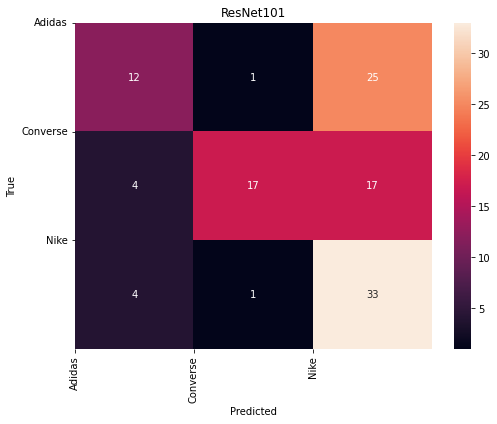

In [49]:
cf_matrix(resnet101_model,"ResNet101")

### InceptionV3

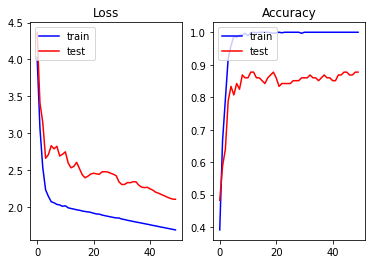

In [50]:
summary_history(inceptionV3_history)

4/4 [==============================] - 1s 68ms/step


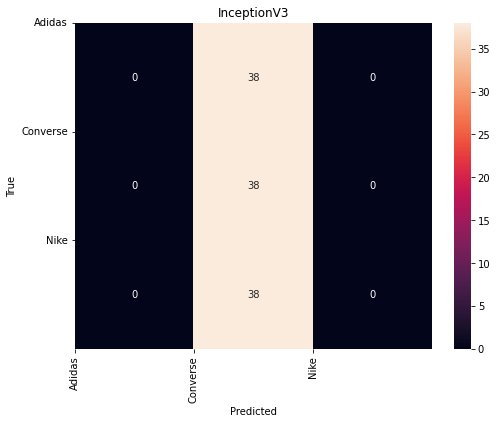

In [51]:
cf_matrix(inceptionV3_model,"InceptionV3")

## <font color='red'>**Utilice este espacio para colocar su análisis (imagenes, tablas, conclusiones, etc.)**

# <font color='blue'>**(50%) Parte 2. Usando Transfer Learning + Regularization**

* (15%) Entrene los 3 modelos originales usando solo transfer learning. Visualice las curvas de Accuracy, Loss y Confusion Matrix

* (25%) Entrene los 3 modelos usando transfer learning + Regularización (considere combinar más de un método). Visualice las curvas de Accuracy, Loss y Confusion Matrix

* (10%)Analice los resultados obtenidos y escriba al menos 3 conclusiones al respecto. 




## Defining Architectures

### VGG16

In [ ]:
def vgg16_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = VGG16(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características
    modelo_base.trainable = trainable
    #-------------------------------------------------------------------
    # Si se requiere regularización entonces:
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    if regulable:
      regularizer = tf.keras.regularizers.l2(0.001)     
      modelo_vgg16 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,          
          # The first fully connected layer 
          LK.GlobalAveragePooling2D(),
          LK.Dense(512, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.BatchNormalization(),
          LK.Dropout(0.3),      
          LK.Dense(1024, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.Dropout(0.15),
          LK.Dense(2048, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.Dropout(0.3),
          LK.Dense(3, activation = "softmax")
      ])
      for i in range(len(modelo_vgg16.layers)):
        if isinstance(modelo_vgg16.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_vgg16.layers[i].name))
          modelo_vgg16.layers[i].kernel_regularizer = regularizer

      """for layer in modelo_vgg16.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)"""

    else:
      modelo_vgg16 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.GlobalAveragePooling2D(),
          LK.Dense(512, activation = "relu"),
          LK.BatchNormalization(),
          LK.Dense(1024, activation = "relu"),
          LK.Dense(2048, activation = "relu"),
          LK.Dense(3, activation = "softmax")
      ])
    #-----------------------------------------------------------------
    modelo_vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_vgg16

### ResNet101

In [ ]:
from keras.applications.resnet import ResNet101
from tensorflow.keras import regularizers

In [ ]:
def resnet101_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = ResNet101(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características
    modelo_base.trainable = trainable
    if regulable:
      regularizer = tf.keras.regularizers.l2(0.01) 
      modelo_resnet101 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,    
          LK.Flatten(),
          LK.Dense(2048, activation=('relu'),  kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
          LK.Dropout(.4), # Adding dropout layer
          LK.Dense(1024, activation=('relu'), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.Dropout(.3),  # Adding dropout layer
          LK.Dense(512, activation=('relu'), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          LK.Dropout(.2),  # Adding dropout layer      
          LK.Dense(3, activation=('softmax'))
      
      ])

      for i in range(len(modelo_resnet101.layers)):
        if isinstance(modelo_resnet101.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_resnet101.layers[i].name))
          modelo_resnet101.layers[i].kernel_regularizer = regularizer
    else:
      modelo_resnet101 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,  
          LK.Flatten(),        
          LK.Dense(2048, activation=('relu')),
          LK.Dropout(.4), # Adding dropout layer
          LK.Dense(1024, activation=('relu')),
          LK.Dropout(.3),  # Adding dropout layer
          LK.Dense(512, activation=('relu')),
          LK.Dropout(.2),  # Adding dropout layer
          LK.Dense(3, activation=('softmax'))
      
      ])

    modelo_resnet101.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_resnet101

### InceptionV3

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
def inceptionV3_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características si está en True
    modelo_base.trainable = trainable
    if regulable:
      regularizer = tf.keras.regularizers.l2(0.001)
      modelo_inceptionV3 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.GlobalMaxPooling2D(),
          LK.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          LK.Dropout(0.3),
          LK.Dense(3,activation='softmax')
      
      ])
      for i in range(len(modelo_inceptionV3.layers)):
        if isinstance(modelo_inceptionV3.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_inceptionV3.layers[i].name))
          modelo_inceptionV3.layers[i].kernel_regularizer = regularizer

    else:
      modelo_inceptionV3 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.GlobalMaxPooling2D(),
          LK.Dense(2048, activation='relu'),
          LK.Dense(3,activation='softmax')
      
      ])

    modelo_inceptionV3.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_inceptionV3

## **Training/visualizing - Transferlearning**

### **Training Architectures - Transfer learning - VGG16**

### Training - VGG16- Transfer

In [ ]:
vgg16_model = vgg16_architecture(trainable=False, regulable=False)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg16_history = train_model(vgg16_model, x_train, y_train, x_test, y_test,epochs=35, preproces_input_algorithm=vgg16_process_input)

Epoch 1/35
8/8 [==============================] - 9s 993ms/step - loss: 1.0326 - accuracy: 0.4734 - val_loss: 1.0934 - val_accuracy: 0.5088
Epoch 2/35
8/8 [==============================] - 9s 1s/step - loss: 0.7043 - accuracy: 0.7385 - val_loss: 1.1085 - val_accuracy: 0.5877
Epoch 3/35
8/8 [==============================] - 8s 918ms/step - loss: 0.5515 - accuracy: 0.8225 - val_loss: 1.0310 - val_accuracy: 0.5877
Epoch 4/35
8/8 [==============================] - 8s 934ms/step - loss: 0.4147 - accuracy: 0.8843 - val_loss: 0.7927 - val_accuracy: 0.6579
Epoch 5/35
8/8 [==============================] - 8s 942ms/step - loss: 0.3588 - accuracy: 0.9002 - val_loss: 0.8059 - val_accuracy: 0.6579
Epoch 6/35
8/8 [==============================] - 8s 924ms/step - loss: 0.2535 - accuracy: 0.9572 - val_loss: 0.6253 - val_accuracy: 0.7368
Epoch 7/35
8/8 [==============================] - 7s 913ms/step - loss: 0.2027 - accuracy: 0.9715 - val_loss: 0.6321 - val_accuracy: 0.7368
Epoch 8/35
8/8 [=======

### Visualizing - VGG16- Transfer

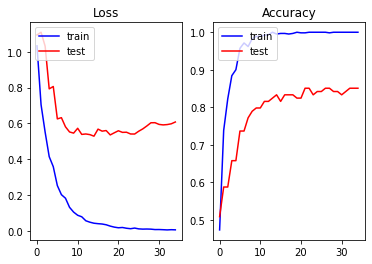

In [ ]:
summary_history(vgg16_history)

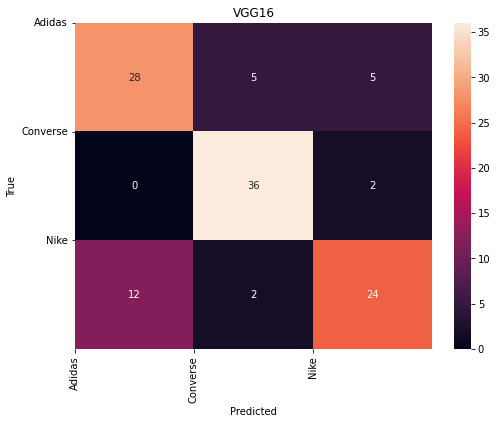

In [ ]:
cf_matrix(vgg16_model,"VGG16")



---



### **Training Architectures - Transfer learning - ResNet101**

### Training - ResNet101 - Transfer

In [ ]:
resnet101_model = resnet101_architecture(trainable=False, regulable=False)

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test, epochs=20, preproces_input_algorithm=resnet101_process_input)

Epoch 1/20
8/8 [==============================] - 16s 1s/step - loss: 43.0531 - accuracy: 0.3597 - val_loss: 8.0851 - val_accuracy: 0.3333
Epoch 2/20
8/8 [==============================] - 8s 954ms/step - loss: 8.7591 - accuracy: 0.4342 - val_loss: 2.6707 - val_accuracy: 0.5614
Epoch 3/20
8/8 [==============================] - 8s 952ms/step - loss: 5.1721 - accuracy: 0.5388 - val_loss: 4.3131 - val_accuracy: 0.4825
Epoch 4/20
8/8 [==============================] - 8s 958ms/step - loss: 3.0583 - accuracy: 0.6688 - val_loss: 1.2520 - val_accuracy: 0.7456
Epoch 5/20
8/8 [==============================] - 8s 958ms/step - loss: 1.6000 - accuracy: 0.7607 - val_loss: 0.9489 - val_accuracy: 0.7544
Epoch 6/20
8/8 [==============================] - 8s 953ms/step - loss: 1.2549 - accuracy: 0.7861 - val_loss: 1.0569 - val_accuracy: 0.7719
Epoch 7/20
8/8 [==============================] - 8s 960ms/step - loss: 0.8308 - accuracy: 0.8304 - val_loss: 0.8346 - val_accuracy: 0.7719
Epoch 8/20
8/8 [=====

### Visualizing - ResNet101 - Transfer

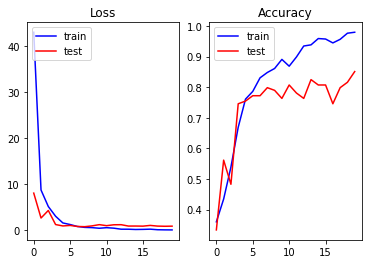

In [ ]:
summary_history(resnet101_history)

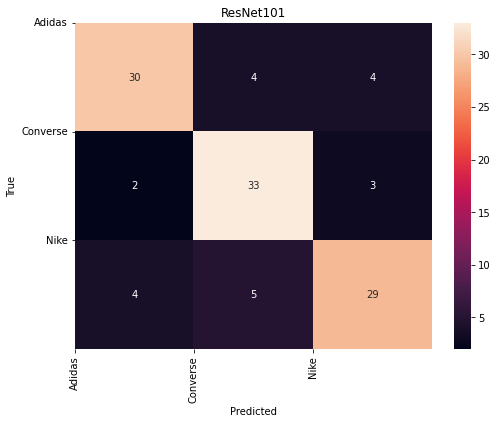

In [ ]:
cf_matrix(resnet101_model,"ResNet101")

### **Training Architectures - Transfer learning - IncenptionV3**

### Training - Incenption V3 - Transfer

In [ ]:
inceptionV3_model = inceptionV3_architecture(trainable=False, regulable=False)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_658 (Conv2D)            (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_658 (Batch  (None, 111, 111, 32  96         ['conv2d_658[0][0]']             
 Normalization)                 )                                                      

In [ ]:
inceptionV3_history = train_model(inceptionV3_model, x_train, y_train, x_test, y_test, epochs=51, preproces_input_algorithm=inceptionv3_preprocess_input)

Epoch 1/51
8/8 [==============================] - 12s 984ms/step - loss: 260.4448 - accuracy: 0.3439 - val_loss: 73.5228 - val_accuracy: 0.3333
Epoch 2/51
8/8 [==============================] - 6s 771ms/step - loss: 24.5336 - accuracy: 0.3534 - val_loss: 8.9794 - val_accuracy: 0.3333
Epoch 3/51
8/8 [==============================] - 6s 760ms/step - loss: 4.6543 - accuracy: 0.3819 - val_loss: 1.0026 - val_accuracy: 0.5351
Epoch 4/51
8/8 [==============================] - 6s 774ms/step - loss: 1.2215 - accuracy: 0.3859 - val_loss: 1.0977 - val_accuracy: 0.4211
Epoch 5/51
8/8 [==============================] - 6s 760ms/step - loss: 1.0562 - accuracy: 0.4453 - val_loss: 0.9493 - val_accuracy: 0.5175
Epoch 6/51
8/8 [==============================] - 6s 758ms/step - loss: 0.8434 - accuracy: 0.6418 - val_loss: 0.8133 - val_accuracy: 0.6842
Epoch 7/51
8/8 [==============================] - 6s 773ms/step - loss: 0.7628 - accuracy: 0.6767 - val_loss: 0.7777 - val_accuracy: 0.6491
Epoch 8/51
8/8 

### Visualizing - InceptionV3 - Transfer

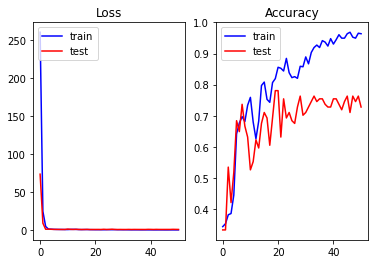

In [ ]:
summary_history(inceptionV3_history)

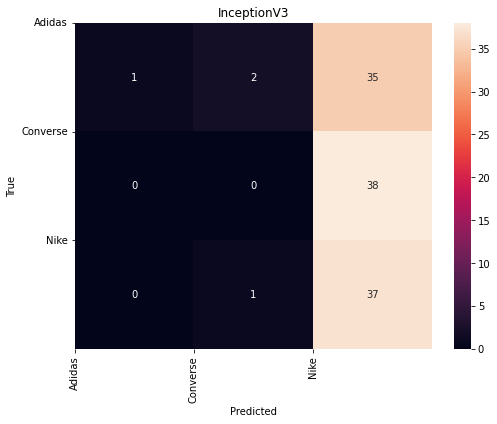

In [ ]:
cf_matrix(inceptionV3_model,"InceptionV3")

## **Training/visualizing - Regularization + Transfer Learning**

### **Training Architectures - Transfer learning - VGG16 + Regularization**

### Training - VGG16- Transfer + Regularization

In [ ]:
vgg16_model = vgg16_architecture(trainable=False, regulable=True)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001


In [ ]:
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
vgg16_history = train_model(vgg16_model, x_train, y_train, x_test, y_test, epochs = 40, callbacks=lr_callbacks, preproces_input_algorithm=vgg16_process_input)

Epoch 1/40
8/8 [==============================] - 9s 991ms/step - loss: 26.6161 - accuracy: 0.3756 - val_loss: 26.6379 - val_accuracy: 0.3947
Epoch 2/40
8/8 [==============================] - 8s 919ms/step - loss: 26.0308 - accuracy: 0.5341 - val_loss: 26.0585 - val_accuracy: 0.5263
Epoch 3/40
8/8 [==============================] - 8s 920ms/step - loss: 25.4273 - accuracy: 0.6482 - val_loss: 25.4119 - val_accuracy: 0.6404
Epoch 4/40
8/8 [==============================] - 8s 918ms/step - loss: 24.9042 - accuracy: 0.7227 - val_loss: 24.9341 - val_accuracy: 0.6491
Epoch 5/40
8/8 [==============================] - 8s 911ms/step - loss: 24.4317 - accuracy: 0.7401 - val_loss: 24.4597 - val_accuracy: 0.6316
Epoch 6/40
8/8 [==============================] - 8s 913ms/step - loss: 23.9410 - accuracy: 0.7781 - val_loss: 23.8466 - val_accuracy: 0.6754
Epoch 7/40
8/8 [==============================] - 7s 910ms/step - loss: 23.4674 - accuracy: 0.8051 - val_loss: 23.3872 - val_accuracy: 0.6754
Epoch 

### Visualizing - VGG16- Transfer + Regularization

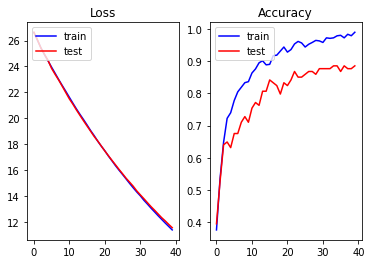

In [ ]:
summary_history(vgg16_history)

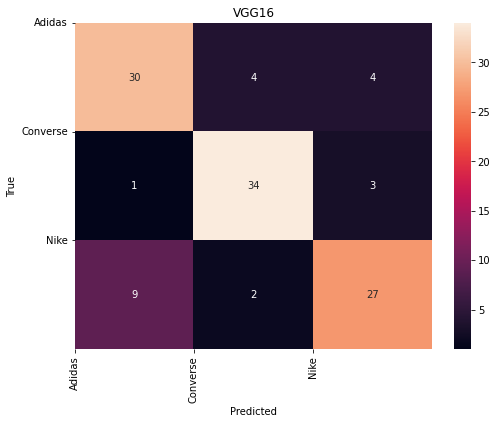

In [ ]:
cf_matrix(vgg16_model,"VGG16")



---



### **Training Architectures - Transfer learning - ResNet101 + Regularization**

### Training - ResNet101 - Transfer + Regularization

In [ ]:
resnet101_model = resnet101_architecture(trainable=False, regulable=True)

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.01


In [ ]:
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
#resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test,  callbacks=lr_callbacks)
resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test, epochs=20, callbacks=lr_callbacks, preproces_input_algorithm=resnet101_process_input)

Epoch 1/20
8/8 [==============================] - 17s 1s/step - loss: 120.8563 - accuracy: 0.3344 - val_loss: 76.8036 - val_accuracy: 0.3333
Epoch 2/20
8/8 [==============================] - 9s 1s/step - loss: 73.2898 - accuracy: 0.3613 - val_loss: 64.0146 - val_accuracy: 0.4474
Epoch 3/20
8/8 [==============================] - 8s 956ms/step - loss: 64.9331 - accuracy: 0.4596 - val_loss: 58.3999 - val_accuracy: 0.6053
Epoch 4/20
8/8 [==============================] - 8s 948ms/step - loss: 56.7022 - accuracy: 0.5325 - val_loss: 51.8858 - val_accuracy: 0.6316
Epoch 5/20
8/8 [==============================] - 8s 965ms/step - loss: 49.1946 - accuracy: 0.6609 - val_loss: 44.8981 - val_accuracy: 0.7456
Epoch 6/20
8/8 [==============================] - 8s 947ms/step - loss: 42.8418 - accuracy: 0.7147 - val_loss: 39.2784 - val_accuracy: 0.8070
Epoch 7/20
8/8 [==============================] - 8s 956ms/step - loss: 37.3168 - accuracy: 0.7940 - val_loss: 34.6729 - val_accuracy: 0.7456
Epoch 8/20

### Visualizing - ResNet101 - Transfer + Regularization

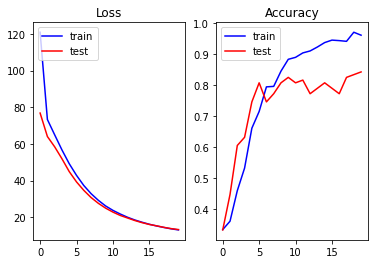

In [ ]:
summary_history(resnet101_history)

4/4 [==============================] - 2s 176ms/step


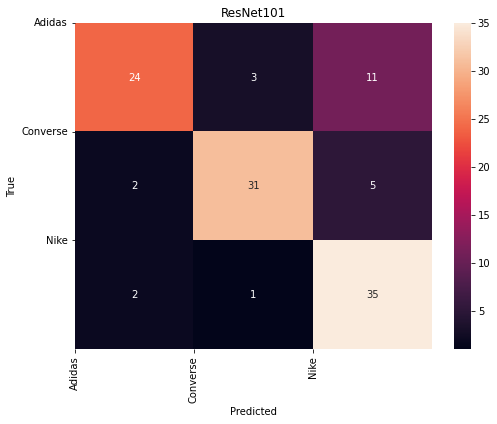

In [ ]:
cf_matrix(resnet101_model,"ResNet101")

### **Training Architectures - Transfer learning - IncenptionV3 + Regularization**

### Training - Incenption V3 - Transfer + Regularization

In [ ]:
inceptionV3_model = inceptionV3_architecture(trainable=False, regulable=True)


In [ ]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.1
    elif epoch > 2 and epoch <= 15:
        return 0.01 
    else:
        return 0.01


In [ ]:
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
inceptionV3_history = train_model(inceptionV3_model, x_train, y_train, x_test, y_test , epochs= 50, callbacks=lr_callbacks,  preproces_input_algorithm=inceptionv3_preprocess_input)

### Visualizing - InceptionV3 - Transfer + Regularization

In [ ]:
summary_history(inceptionV3_history)

In [ ]:
cf_matrix(inceptionV3_model,"InceptionV3")